# Ridge regression

In [1]:
library(tidyverse)

#install.packages('hablar')
#library(hablar)

#install.packages("tidyr")
#install.packages("rlang")
library(tidyr)

#install.packages('scales')
library(scales)

library(LICORS)

#install.packages("slider")
library(slider)

library(glmnet)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accum

## Read in the data

In [2]:
sum_control_ATAC_bin_rm = read.csv("data/sum_control_normalized_ATAC_bin_rm.csv")
sum_control_ATAC = read.csv("data/sum_control_normalized_ATAC.csv")

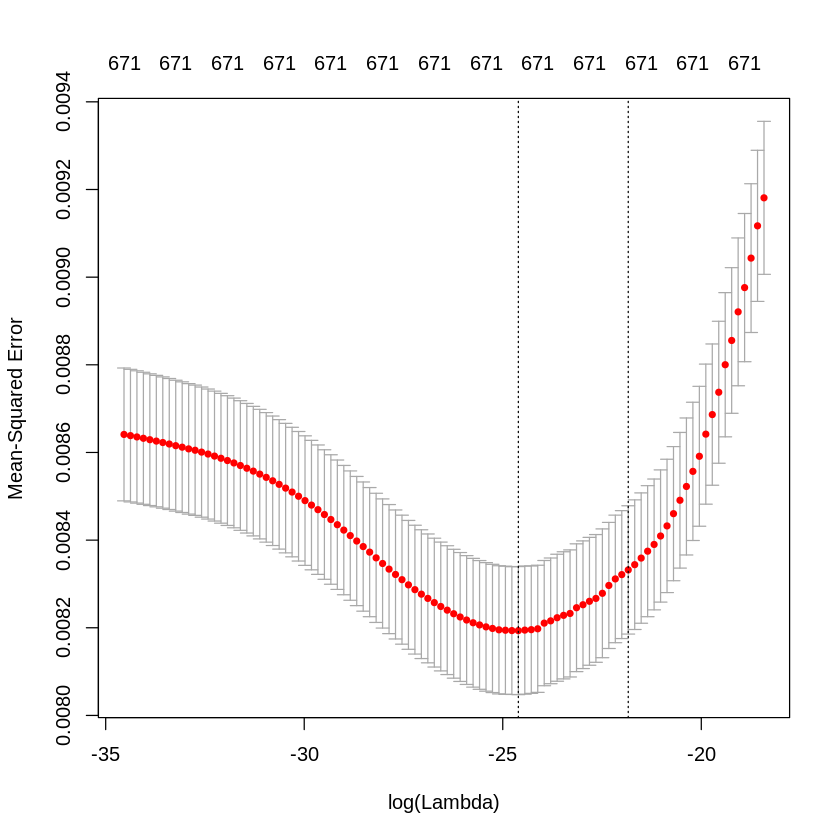

In [3]:
set.seed(0)
#X==predictor
#y==response


y <- sum_control_ATAC_bin_rm %>% dplyr::select(ATAC_val) %>%  as.matrix()
X <- sum_control_ATAC_bin_rm %>% dplyr::select(-ATAC_val) %>% as.matrix()

ridge_lambdas_to_try <- 10^seq(-15, -8, length.out = 100)
#-15 and -8 for not standardized
#- 10 an 0 for standardized

ridge_cv <- cv.glmnet(X, y, alpha = 0, lambda = ridge_lambdas_to_try,
                      standardize = FALSE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(ridge_cv)

In [4]:
ridge_lambda_cv <- ridge_cv$lambda.min

In [5]:
CV_ridge<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- data %>% dplyr::select(ATAC_val) %>%  as.matrix()
    X <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 0, lambda = ridge_lambda_cv, standardize = FALSE)
        tmp       <- predict(fit, s=ridge_lambda_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [6]:
res_ridge_pred <- CV_ridge(sum_control_ATAC_bin_rm, 10)
#head(res_ridge_pred)

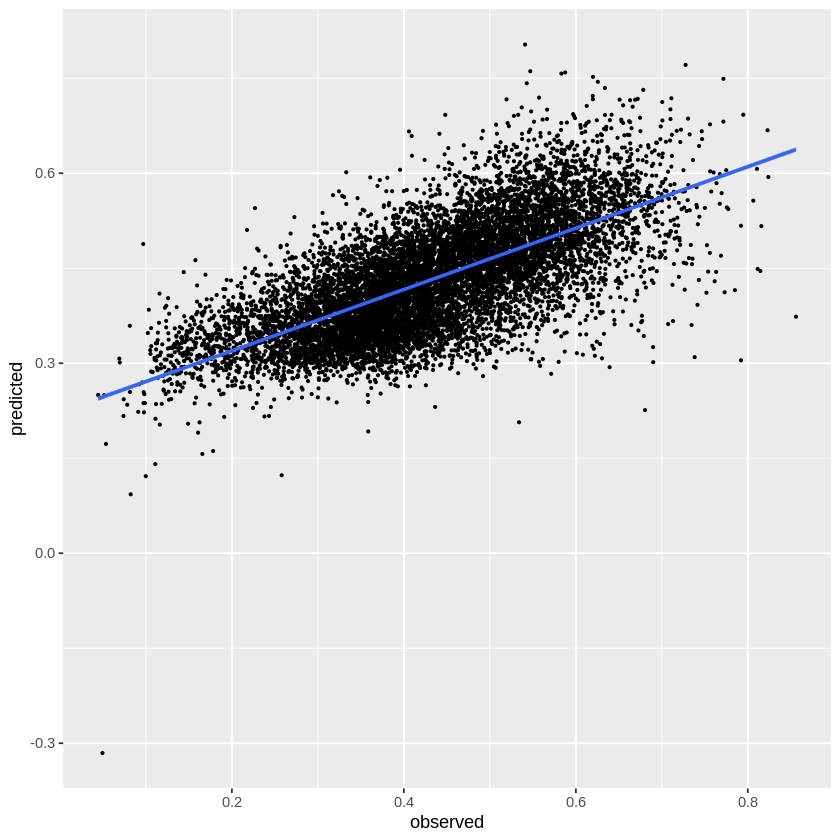

In [7]:
ggplot(res_ridge_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [8]:
cor(res_ridge_pred$observed, res_ridge_pred$predicted)
#Correlation, standardized = FALSE --> 0.6902411
#Correlation, standardized = TRUE --> 0.6785781

ATAC_val,0.6902411


## Extracting predictors

In [9]:
y <- sum_control_ATAC_bin_rm %>% dplyr::select(ATAC_val) %>%  as.matrix()
X <- sum_control_ATAC_bin_rm %>% dplyr::select(-ATAC_val) %>% as.matrix()

model <- glmnet(X, y, alpha = 0, lambda = ridge_lambda_cv, standardize = FALSE)

In [10]:
predictors_used<-tibble(predictors=as.vector(rownames(model$beta)),coefficient=as.vector(model$beta)) %>% filter(coefficient!=0)

predictors_used<- predictors_used %>%
  arrange(desc(abs(coefficient)))

In [11]:
sum(abs(predictors_used$coefficient) < 0.5)

[1] 27